In [1]:
import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sns.set(rc={'axes.facecolor':'beige', 'figure.facecolor':'beige'})

In [3]:
db = dataset.connect("sqlite:///dunks.db")
dunks_table = db['dunks']
players_table = db['players']
games_table = db['games']

In [4]:
east_all_stars = ["Kyrie Irving",
"DeMar DeRozan",
"LeBron James",
"Jimmy Butler",
"Giannis Antetokounmpo",
"Isaiah Thomas",
"John Wall",
"Kevin Love",
"Carmelo Anthony",
"Kyle Lowry",
"Paul George",
"Kemba Walker",
"Paul Millsap"]

In [5]:
west_all_stars = ["Stephen Curry",
"James Harden",
"Kevin Durant",
"Kawhi Leonard",
"Anthony Davis",
"Russell Westbrook",
"Klay Thompson",
"Draymond Green",
"DeMarcus Cousins",
"Marc Gasol",
"DeAndre Jordan",
"Gordon Hayward"]

In [6]:
all_stars = []
all_stars.extend(east_all_stars)
all_stars.extend(west_all_stars)

In [7]:
player_stats = []
for player in all_stars:
    first_name = player.split(' ')[0]
    last_name = player.split(' ')[1]
    player_stats.append(dict(list(players_table.find(season=2016, first_name=first_name, 
                            last_name=last_name))[0]))
player_df = pd.DataFrame.from_dict(player_stats)

In [8]:
player_df.set_index('player_id', inplace=True)

In [9]:
east_dunks = []
for player in east_all_stars:
    first_name = player.split(' ')[0]
    last_name = player.split(' ')[1]
    player_id = dict(list(players_table.find(season=2016, first_name=first_name, 
                            last_name=last_name))[0])['player_id']
    east_dunks.extend([dict(dunk) for dunk in list(db.query('''SELECT * FROM dunks WHERE SEASON = 2016 
    AND TEAM NOT LIKE 'EAST' 
    AND TEAM NOT LIKE 'WEST'
    AND PLAYER_ID LIKE '{0}'
    '''.format(str(player_id))))])

In [10]:
west_dunks = []
for player in west_all_stars:
    first_name = player.split(' ')[0]
    last_name = player.split(' ')[1]
    player_id = dict(list(players_table.find(season=2016, first_name=first_name, 
                            last_name=last_name))[0])['player_id']
    west_dunks.extend([dict(dunk) for dunk in list(db.query('''SELECT * FROM dunks WHERE SEASON = 2016 
    AND TEAM NOT LIKE 'EAST' 
    AND TEAM NOT LIKE 'WEST'
    AND PLAYER_ID LIKE '{0}'
    '''.format(str(player_id))))])

In [11]:
len(west_dunks)

565

In [12]:
len(east_dunks)

353

In [13]:
combined_dunks = []
combined_dunks.extend(east_dunks)
combined_dunks.extend(west_dunks)

### Dunks by All Stars

Giannis 'Greek Freak' Antetokounmpo lead all 2016-17 All Stars in dunks made this season, with Deandre Jordan close behind. Unsurprisingly, Anthony Davis, LeBron James, and Kevin Durant rounded out the top five most prolific dunkers in the All-Star cast. By looking at the number of missed dunks in the season you're able to discern something about each player's finishing ability. DeAndre Jordan lead the All-Stars in number of missed dunks (9) and finished the year with a dunking accuracy of 93.8%. Anthony Davis had the next lowest dunking accuracy (93.7%) followed by Russell Westbrook (93.5%), and Jimmy Butler (90.0%). However, it's important to note that Jimmy Butler only attempted a total of 20 dunks in the entire 2016-17 season. 

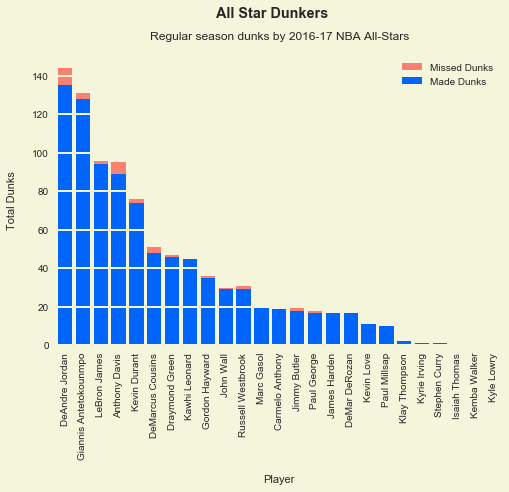

In [14]:
df = pd.DataFrame.from_dict(combined_dunks)
df['miss'] = df.apply(lambda x: 0 if x['make'] else 1, axis=1)

df.set_index('id', inplace=True)

total_dunks_by_player = df.groupby('player_id')['make', 'miss'].sum()

total_dunks_df = pd.DataFrame(total_dunks_by_player)

last_name = []
first_name = []
for ix in total_dunks_by_player.index:
    last_name.append(player_df.loc[ix, :]['last_name'])
    first_name.append(player_df.loc[ix, :]['first_name'])
total_dunks_df['last_name'] = last_name
total_dunks_df['first_name'] = first_name

total_dunks_df.reset_index(inplace=True)

total_dunks_df['full_name'] = total_dunks_df.first_name+" "+total_dunks_df.last_name

for non_dunker in list((set(east_all_stars+west_all_stars)-set(total_dunks_df.full_name))):
    first_name = non_dunker.split(' ')[0]
    last_name = non_dunker.split(' ')[1]
    player_id = dict(list(players_table.find(season=2016, first_name=first_name, 
                        last_name=last_name))[0])['player_id']
    total_dunks_df.loc[len(total_dunks_df)] = [player_id, 0, 0, last_name, first_name, non_dunker]

total_dunks_df.sort_values('make', inplace=True, ascending=False)

sns.set(rc={'axes.facecolor':'beige', 'figure.facecolor':'beige'})
ax = sns.barplot(x=[i for i in xrange(len(total_dunks_df.index))], y=total_dunks_df['make']+total_dunks_df['miss'], color='salmon', label='Missed Dunks', zorder=-1, saturation=1)
sns.barplot(x=[i for i in xrange(len(total_dunks_df.index))], y=total_dunks_df['make'], color=sns.xkcd_rgb["bright blue"], label='Made Dunks', zorder=-1, saturation=1)
ax.set_xticklabels(total_dunks_df.full_name, rotation=90)
ax.yaxis.grid(True, linewidth=2.0, color='beige')
ax.figure.subplots_adjust(top=0.86)
ax.set_ylabel('Total Dunks', labelpad=15)
ax.set_xlabel('Player', labelpad=15)
ax.set_title("Regular season dunks by 2016-17 NBA All-Stars", y=1.03, fontsize=12)
ax.figure.suptitle("All Star Dunkers", fontweight='bold')
ax.legend()
ax.figure.savefig('all_star_dunks.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [15]:
total_dunks_df['d_pct'] = total_dunks_df.make/(total_dunks_df.make+total_dunks_df.miss)

In [16]:
total_dunks_df.sort_values('d_pct', na_position='first')

,player_id,make,miss,last_name,first_name,full_name,d_pct
22,thomais02,0,0,Thomas,Isaiah,Isaiah Thomas,NaN
23,walkeke02,0,0,Walker,Kemba,Kemba Walker,NaN
24,lowryky01,0,0,Lowry,Kyle,Kyle Lowry,NaN
2,butleji01,18,2,Butler,Jimmy,Jimmy Butler,0.900000
21,westbru01,29,2,Westbrook,Russell,Russell Westbrook,0.935484
5,davisan02,89,6,Davis,Anthony,Anthony Davis,0.936842
15,jordade01,135,9,Jordan,DeAndre,DeAndre Jordan,0.937500
3,couside01,48,3,Cousins,DeMarcus,DeMarcus Cousins,0.941176
9,georgpa01,17,1,George,Paul,Paul George,0.944444
20,walljo01,29,1,Wall,John,John Wall,0.966667


## "Dunk City"

When Chris Paul was traded to the Los Angeles Clippers in the (FILL IN) season, LA was christened "Lob City" in expectation of lob passes from Paul to Blake Griffin for flashy ally-oop dunks. But what team really provided their fan bases with the most slam dunks per game since 2003?

Although no one team had a statistically significant lead over all other teams in the league, Oklahoma City and Denver averaged the most dunks per game over the last thirteen seasons. Thunder fans could expect to see on average around 3.44 dunks per game, whereas Nugget fans were treated to about 3.26 dunks per night. Of course its important to note that the Oklahoma City Thunder have only been established since 2008, which gives them less opportunity to have a particularly underwhelming year of dunks.

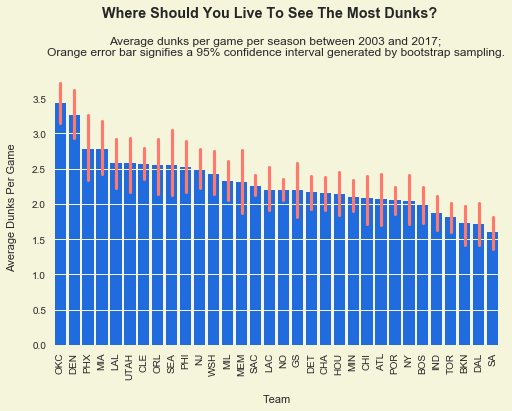

In [17]:
gps = {}
for s in xrange(2003, 2017):
    if s != 2011:
        gps[s] = 82
    else:
        gps[s] = 66

all_teams = np.unique([dunk['team'] for dunk in dunks_table.all()])

grouped_dunk_dicts = []
for team in all_teams:
    if team not in ['WEST', 'EAST']:
        team_dunks = list(dunks_table.find(team=team, season=gps.keys()))
        df = pd.DataFrame(team_dunks)
        df['miss'] = df.apply(lambda x: 0 if x['make'] else 1, axis=1)
        grouped = df.groupby('season').sum().loc[:,['make']]
        dunk_dict = dict(zip(grouped.index, grouped.make))
        grouped_dunk_dicts.append({team : dunk_dict})

dfs = []
for t_dunks in grouped_dunk_dicts:
    df = pd.DataFrame.from_dict(t_dunks)
    dfs.append(df)
df_dps = pd.concat(dfs, axis=1)

df_dpg = pd.DataFrame()
for ix in df_dps.index:
    df_dpg[ix] = df_dps.ix[ix, :]/gps[ix]


    
ax = sns.barplot(data=df_dpg.T, color=sns.xkcd_rgb['bright blue'], order=list(df_dpg.T.mean().sort_values(ascending=False).index), errcolor=sns.xkcd_rgb['salmon'], zorder=-1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.grid(1, color='beige')
ax.figure.subplots_adjust(top=0.82)
ax.set_ylabel('Average Dunks Per Game', labelpad=15)
ax.set_xlabel('Team', labelpad=15)
ax.set_title("Average dunks per game per season between 2003 and 2017; \nOrange error bar signifies a 95% confidence interval generated by bootstrap sampling.", y=1.03, fontsize=12)
ax.figure.suptitle("Where Should You Live To See The Most Dunks?", fontweight='bold')
ax.figure.savefig('avg_team_dpg.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

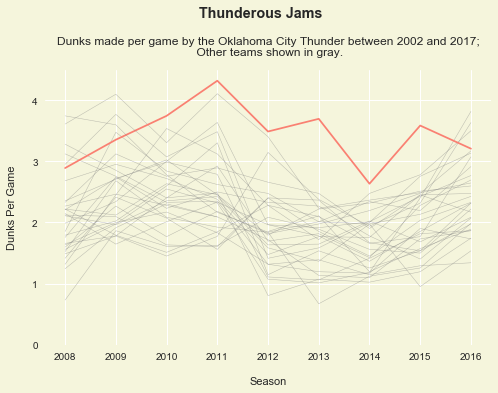

In [18]:
ax = plt.subplot()
ax.set_title('OKC Average Dunks Per Game By Season')
for ix in df_dpg.index:
    if ix != 'OKC':
        years = [year for year in df_dpg.columns if int(year) > 2007]
        ax.plot(years, df_dpg.T.ix[years,ix], color='grey', alpha=0.5, linewidth=.5)
    else:
        ax.plot(df_dpg.columns, df_dpg.T[ix], color='salmon')
ax.set_ylim(bottom=0)
ax.figure.subplots_adjust(top=0.82)
ax.set_ylabel('Dunks Per Game', labelpad=15)
ax.set_xlabel('Season', labelpad=15)
ax.set_title("Dunks made per game by the Oklahoma City Thunder between 2002 and 2017;\n Other teams shown in gray.", y=1.03, fontsize=12)
ax.figure.suptitle("Thunderous Jams", fontweight='bold')
ax.figure.savefig('OKC_dpg.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

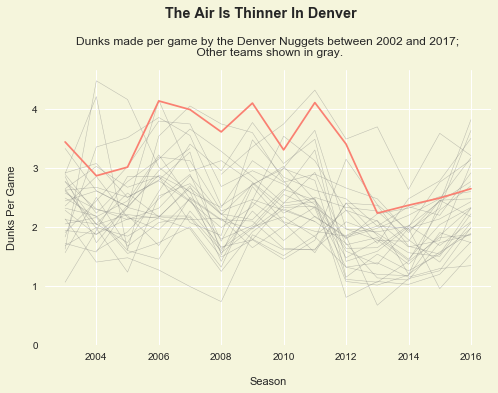

In [19]:
ax = plt.subplot()
ax.set_title('DEN Dunks Per Game By Season')
for ix in df_dpg.index:
    if ix != 'DEN':
        ax.plot(df_dpg.columns, df_dpg.T[ix], color='grey', alpha=0.5, linewidth=.5)
    else:
        ax.plot(df_dpg.columns, df_dpg.T[ix], color='salmon', zorder=4)
ax.set_ylim(bottom=0)
ax.figure.subplots_adjust(top=0.82)
ax.set_ylabel('Dunks Per Game', labelpad=15)
ax.set_xlabel('Season', labelpad=15)
ax.set_title("Dunks made per game by the Denver Nuggets between 2002 and 2017;\n Other teams shown in gray.", y=1.03, fontsize=12)
ax.figure.suptitle("The Air Is Thinner In Denver", fontweight='bold')
ax.figure.savefig('DEN_dpg.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

On the low end of the "Dunk City" competition is San Antonio, Dallas, and Brooklyn. San Antonio, perhaps as a result of Gregg Popovich's no-nonsense conservative coaching style, averaged only 1.60 dunks per game over the last 13 years. In fact, in 2008, San Antonio averaged a mere 0.73 dunks per game, the second lowest of any team in that same time span (the Atlanta Hawks had only 0.67 dunks per game during their 2013-14 season).

## Top Individual Dunkers

If Oklahoma City is the place to go to see the most dunks, what is the best player to watch to see the same thing? Unsurprisingly, it was Shaquille O'Neal throughout the early to mid 2000s. Shaq Diesel managed to jam 2.82 times per game in his 2004-05 season with the Miami Heat. O'Neal also had some impressive dunking seasons in 2005-06 and 2003-04, dunking on average 2.51 per game and 2.52 per game, respectively. Amar'e Stoudamire and Dwight Howard also were consistently throwing down a high number of dunks per game in the late 2000s, with Stoudamire having his best season in 2007-08 (2.19 dunks per game) and Howard in 2006-07 (2.11 dunks per game).

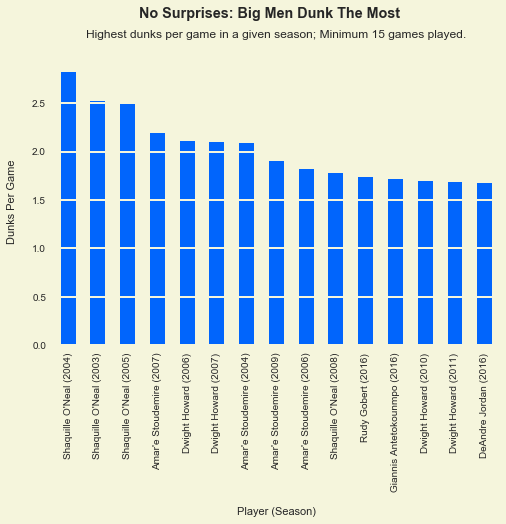

In [20]:
df_all_dunks = pd.DataFrame(list(dunks_table.find(season=gps.keys())))
df_all_dunks = df_all_dunks[(df_all_dunks['team'] != 'WEST') | (df_all_dunks['team'] != 'EAST')]
df_all_dunks['miss'] = df_all_dunks['make'].apply(lambda x: 0 if x else 1)

df_group_p_s = df_all_dunks.groupby(['player_id', 'season']).sum()
df_group_p_s = df_group_p_s[['make', 'miss']]

full_player_df = pd.DataFrame(list(players_table.find(season=gps.keys())))
full_s_d_grouped = full_player_df.join(df_group_p_s, on=['player_id', 'season'])
full_s_d_grouped['full_name'] = full_s_d_grouped.first_name+' '+full_s_d_grouped.last_name
full_s_d_grouped['season_str'] = full_s_d_grouped.season.apply(lambda x: str(x))
full_s_d_grouped['full_name_season'] = full_s_d_grouped.full_name+' ('+full_s_d_grouped.season_str+')'

full_s_d_grouped['dpg'] = full_s_d_grouped['make']/full_s_d_grouped['g']
full_s_d_grouped['dpm'] = full_s_d_grouped['make']/full_s_d_grouped['mp']
full_s_d_grouped['d_pct'] = full_s_d_grouped['make']/(full_s_d_grouped['make']+full_s_d_grouped['miss'])

full_s_d_grouped.sort_values('dpg', ascending=False, inplace=True)

top_dpg_df = full_s_d_grouped[full_s_d_grouped['g'] > 15][['make', 'dpg', 'dpm', 'd_pct', 'season', 'last_name', 'first_name', 'g', 'teams', 'full_name_season']]

ax = top_dpg_df[:15].plot('full_name_season', 'dpg', kind='bar', color=sns.xkcd_rgb['bright blue'], zorder=-3)
ax.set_title('Highest Dunks Per Game in Season by Player')
ax.set_xlabel('Player (Season)', labelpad=15)
ax.set_ylabel('Dunks Per Game', labelpad=15)
ax.yaxis.grid(1, color='beige', linewidth=2.0)
ax.xaxis.grid(0)
ax.legend_.remove()

ax.figure.subplots_adjust(top=0.85)
ax.set_title("Highest dunks per game in a given season; Minimum 15 games played.", y=1.05, fontsize=12)
ax.figure.suptitle("No Surprises: Big Men Dunk The Most", fontweight='bold')
ax.figure.savefig('top_dpg.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [21]:
top_dpg_df.head()

,make,dpg,dpm,d_pct,season,last_name,first_name,g,teams,full_name_season
1218,206.0,2.821918,0.082665,0.962617,2004,O'Neal,Shaquille,73,MIA,Shaquille O'Neal (2004)
764,169.0,2.522388,0.068588,0.960227,2003,O'Neal,Shaquille,67,LAL,Shaquille O'Neal (2003)
1674,148.0,2.508475,0.081949,0.925000,2005,O'Neal,Shaquille,59,MIA,Shaquille O'Neal (2005)
2669,173.0,2.189873,0.064625,0.971910,2007,Stoudemire,Amar'e,79,PHO,Amar'e Stoudemire (2007)
2014,173.0,2.109756,0.057228,0.966480,2006,Howard,Dwight,82,ORL,Dwight Howard (2006)


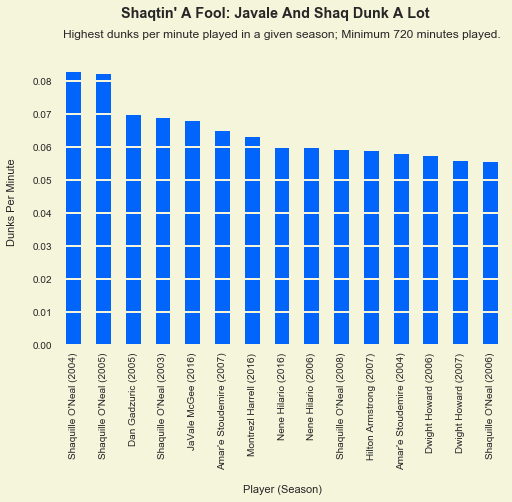

In [22]:
full_s_d_grouped.sort_values('dpm', ascending=False, inplace=True)

top_dpg_df = full_s_d_grouped[full_s_d_grouped['mp'] > 48*15][['make', 'dpg', 'dpm', 'd_pct', 'season', 'last_name', 'first_name', 'g', 'teams', 'full_name_season']]

ax = top_dpg_df[:15].plot('full_name_season', 'dpm', kind='bar', color=sns.xkcd_rgb['bright blue'], zorder=-3)
ax.set_title('Highest Dunks Per Minute in Season by Player')
ax.set_xlabel('Player (Season)', labelpad=15)
ax.set_ylabel('Dunks Per Minute', labelpad=15)
ax.yaxis.grid(1, color='beige', linewidth=2.0)
ax.xaxis.grid(0)
ax.legend_.remove()

ax.figure.subplots_adjust(top=0.85)
ax.set_title("Highest dunks per minute played in a given season; Minimum 720 minutes played.", y=1.05, fontsize=12)
ax.figure.suptitle("Shaqtin' A Fool: Javale And Shaq Dunk A Lot", fontweight='bold')
ax.figure.savefig('top_dpm.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

Per minutes played Shaq still leads the rest of the NBA in dunks in a single season. Dan Gadzuric, a lesser known Dutch national who played at center in the NBA for 10 years, dunked 0.07 times per minute in his 2005-06 with the Milwaukee Bucks. Another surprise on the list of players with high dunks per minute averages is Javale McGee. McGee, who is famous for his unpolished basketball game, managed to hit 0.07 dunks per game in the 2016-17 season with the Golden State Warriors.

/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


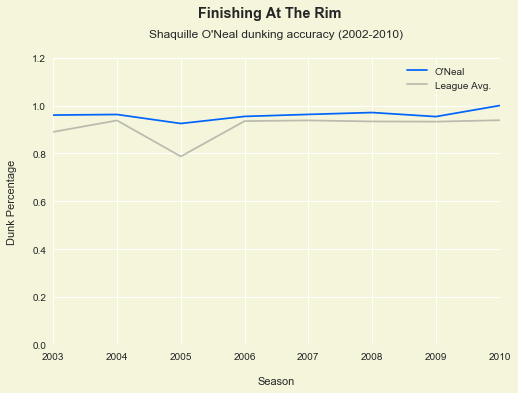

In [23]:
shaq_df = full_s_d_grouped[(full_s_d_grouped['first_name'] == 'Shaquille') & (full_s_d_grouped['last_name'] == "O'Neal")]
avg_df = pd.DataFrame(full_s_d_grouped.groupby('season').mean()['d_pct'])
avg_df.reset_index(inplace=True)

shaq_df.sort_values('season', inplace=True)
ax = shaq_df.plot('season', 'd_pct', kind='line', color=sns.xkcd_rgb['bright blue'], label="O'Neal")
ax.figure.subplots_adjust(top=0.85)
avg_df[avg_df['season'] < 2011].plot('season', 'd_pct', kind='line', color='gray', ax=ax, alpha=0.5, label='League Avg.')
ax.set_title("Shaquille O'Neal dunking accuracy (2002-2010)", y=1.05, fontsize=12)
ax.set_xlabel('Season', labelpad=15)
ax.set_ylabel('Dunk Percentage', labelpad=15)
ax.grid(1, color='white')
ax.set_ylim(0, 1.2)

ax.figure.suptitle("Finishing At The Rim", fontweight='bold')
ax.figure.savefig('shaq_dunk_acc.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

Not only has O'Neal been the most prolific dunker in the last 13 seasons, but also a consistent finisher at the rim. For someone with such a high number of attempts, Shaq was able to stay well above the average league dunking accuracy between 2003 and 2010.

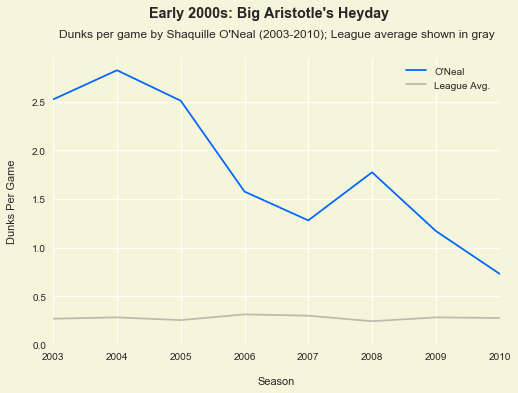

In [24]:
ax = shaq_df.plot('season', 'dpg', kind='line', color=sns.xkcd_rgb['bright blue'], label="O'Neal")
avg_df = pd.DataFrame(full_s_d_grouped.groupby('season').mean()['dpg'])
avg_df.reset_index(inplace=True)
avg_df[avg_df['season'] < 2011].plot('season', 'dpg', ax=ax, color='gray', alpha=0.5, label='League Avg.')
ax.set_title("Dunks per game by Shaquille O'Neal (2003-2010); League average shown in gray", y=1.05, fontsize=12)
ax.set_xlabel('Season', labelpad=15)
ax.set_ylabel('Dunks Per Game', labelpad=15)
ax.grid(1, color='white')
ax.set_ylim(0)

ax.figure.subplots_adjust(top=0.85)
ax.figure.suptitle("Early 2000s: Big Aristotle's Heyday", fontweight='bold')
ax.figure.savefig('shaq_dpg.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

However, with time being the great equalizer, it is not a shock that Shaq's dunks per game fell nearly monotonically after his 2004-05 season with the Miami Heat. By the time he retired after the 2010-11 season, Shaq's dunks per game had fallen to well below 1.0 (total attempts = 27, per game 0.72). Yet, he still stayed well above the league average in all 7 of his seasons analyzed.


In [25]:
shaq_df.head()

,id,fg2a,last_name,gs,fg_pct,pos,fg2,fg3,player_id,pts,...,mp,drb,make,miss,full_name,season_str,full_name_season,dpg,dpm,d_pct
764,1192,948,O'Neal,67,0.584,C,554,0,onealsh01,1439,...,2464,523,169.0,7.0,Shaquille O'Neal,2003,Shaquille O'Neal (2003),2.522388,0.068588,0.960227
1218,1646,1095,O'Neal,73,0.601,C,658,0,onealsh01,1669,...,2492,507,206.0,8.0,Shaquille O'Neal,2004,Shaquille O'Neal (2004),2.821918,0.082665,0.962617
1674,2102,800,O'Neal,58,0.600,C,480,0,onealsh01,1181,...,1806,369,148.0,12.0,Shaquille O'Neal,2005,Shaquille O'Neal (2005),2.508475,0.081949,0.925000
2133,2561,479,O'Neal,39,0.591,C,283,0,onealsh01,690,...,1135,200,63.0,3.0,Shaquille O'Neal,2006,Shaquille O'Neal (2006),1.575000,0.055507,0.954545
2590,3018,558,O'Neal,61,0.593,C,331,0,onealsh01,832,...,1748,388,78.0,3.0,Shaquille O'Neal,2007,Shaquille O'Neal (2007),1.278689,0.044622,0.962963


/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


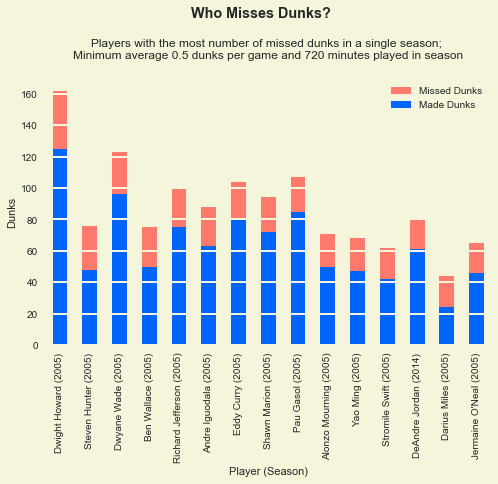

In [26]:
freq_dunkers_df = full_s_d_grouped[(full_s_d_grouped['dpg'] >= .5) & (full_s_d_grouped['mp'] > 15*48)]
freq_dunkers_df['dunk_att'] = freq_dunkers_df['make'] + freq_dunkers_df['miss']
freq_dunkers_df.sort_values('miss', inplace=True, ascending=False)

ax = freq_dunkers_df[:15].plot('full_name_season', 'dunk_att', kind='bar', color=sns.xkcd_rgb['salmon'], label='Missed Dunks', zorder=-1)


freq_dunkers_df[:15].plot('full_name_season', 'make', kind='bar', color=sns.xkcd_rgb['bright blue'], ax = ax, label='Made Dunks', zorder=-1)
ax.set_title('Players with the most missed dunks in a season that averaged \nmore than 0.5 dunks per game and played more than 720 minutes')
ax.set_xlabel('Player (Season)')
ax.set_ylabel('Dunks')

ax.set_title("Players with the most number of missed dunks in a single season; \nMinimum average 0.5 dunks per game and 720 minutes played in season", y=1.05, fontsize=12)

ax.yaxis.grid(1, color='beige', linewidth=2.0)
ax.xaxis.grid(0)
ax.figure.subplots_adjust(top=0.8)
ax.figure.suptitle("Who Misses Dunks?", fontweight='bold')
ax.figure.savefig('missed_dunks.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

For someone who has watched the NBA it might be surprising to see dunking accuracy statistics that are well below 100%. In fact, players, even those at the center position, do miss dunks fairly frequently. Dwight Howard's season in 2005-06 was a particularly poor display of accuracy at the rim. Howard, a muscular 6'11'' center weighing in around 265 lbs, managed to miss on average 23 out of 100 dunks attempted. But that didn't stop him from trying: on the season, he attempted a total of 162 dunks, making only 125. Darius Miles, a small forward that played for the Portland Trailblazers in the 2005-06 season, had a shockingly abysmal accuracy at the rim. Out of 44 attempts on the season, Miles was able to convert only 24 (54.5%). 

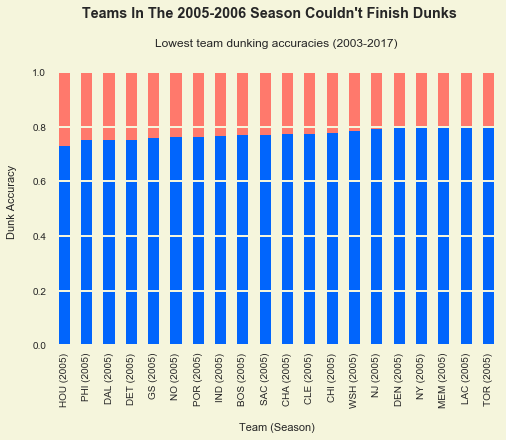

In [29]:
df_d_t_s = df_all_dunks.groupby(['team', 'season']).sum()
df_d_t_s['d_pct'] = df_d_t_s['make']/(df_d_t_s['make']+df_d_t_s['miss']) 
df_d_t_s.sort_values('d_pct', inplace=True)
df_d_t_s.reset_index(inplace=True)
df_d_t_s = df_d_t_s[(df_d_t_s['team'] != 'EAST') & (df_d_t_s['team'] != 'WEST')]
df_d_t_s['season_str'] = df_d_t_s['season'].apply(lambda x: str(x))
df_d_t_s['season_team'] = df_d_t_s['team'] + ' (' + df_d_t_s['season_str'] + ')'
df_d_t_s['1'] = 1
ax = df_d_t_s[:20].plot('season_team', '1', kind='bar', color=sns.xkcd_rgb['salmon'], zorder=-1)
ax.set_ylabel('Dunk Accuracy', labelpad=15)
df_d_t_s[:20].plot('season_team', 'd_pct', kind='bar', color=sns.xkcd_rgb['bright blue'], ax=ax, zorder=-1)
ax.set_xlabel('Team (Season)', labelpad=15)
ax.xaxis.grid(0)
ax.yaxis.grid(1, color='beige', linewidth=2)
ax.figure.suptitle("Teams In The 2005-2006 Season Couldn't Finish Dunks", fontweight='bold')
ax.figure.subplots_adjust(top=0.85)
ax.set_title("Lowest team dunking accuracies (2003-2017)", y=1.02, fontsize=12)
ax.legend_.remove()

ax.figure.savefig('Blog Post 1/low_team_acc.png', edgecolor='beige', facecolor='beige', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [28]:
df_d_t_s[df_d_t_s.season > 2011].head()

,team,season,day,month,year,game_id,make,minute,second,miss,d_pct,season_str,season_team,1
37,GS,2014,1859.0,674.0,231682.0,46066579499,97,636,3507,18,0.843478,2014,GS (2014),1
40,NY,2012,1445.0,638.0,221389.0,44030769450,94,593,3703,16,0.854545,2012,NY (2012),1
41,LAC,2014,2544.0,925.0,320321.0,63692040595,136,893,4786,23,0.855346,2014,LAC (2014),1
42,LAC,2015,3063.0,1008.0,338622.0,67339197404,145,857,4992,23,0.863095,2015,LAC (2015),1
55,LAC,2013,2995.0,992.0,392670.0,78095458094,172,1025,5633,23,0.882051,2013,LAC (2013),1


Sometimes teams collectively have trouble finishing at the rim as well as individual players. It seems that across the league in 2005, dunk accuracies were extremely low. The Houston Rockets were at the very bottom over the last 13 seasons, averaging 72.8% accuracy (on 180 attempts). Philadelphia had the next lowest average, finishing on a mere 75.2% of dunks on a total of 330 dunks. More recently, the teams with the lowest dunking accuracies have been the 2014-15 Golden State Warriors (84.3%), the 2012-13 New York Knicks (85.5%), and the 2014-15 Los Angeles Clippers (85.5%).